# Basic Strategy Experimentation

This notebook contains various experiments involving backtesting very simple trading strategies in order to get familiar with [`backtesting.py`](https://kernc.github.io/backtesting.py/), a Python package providing an intuitive framework for backtesting trading strategies.

## Table of Contents
1. [Introduction](#Introduction)
2. [Buy and Hold Strategy](#buy-and-hold-strategy)
3. [SMA Crossover Strategy](#SMA-crossover-strategy)
4. [RSI Based Strategy](#RSI-Based-Strategy)
5. [Next Steps](#Next-Steps)

In [1]:
import os
import sys

# add root directory to path for helper functions
if os.path.abspath("../") not in sys.path:
    sys.path.append(os.path.abspath("../"))

import warnings
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from helper_functions.plots_helper import plot_position
from helper_functions.indicators import sma, rsi

warnings.filterwarnings("ignore")

## Introduction

Backtesting is to algorithmic trading what model evaluation is to data science and machine learning. Various packages on PyPI provide frameworks for backtesting, and for this learning project, `backtesting.py` was chosen due to its intuitive and easy-to-understand design. While this package has some drawbacks, such as limited integration with broker services and a restricted set of built-in features, it offers a solid foundation for learning the fundamental principles of backtesting. This should make transitioning to more advanced backtesting packages easier in the future.

Note that in order to run use the plotting features in `backtesting.py`, the [`bokeh`](https://bokeh.org) package had to be downgraded to version 3.2.1. The `bokeh` package provides interactive plots in the form of a html page. All of the html pages from this notebook are stored in the plots folder.

Similar to [notebook 01](01_stock_data_exploration.ipynb), we will be working with Google daily data from 2023.

In [2]:
google_data_daily = yf.download(
    "GOOG", interval="1d", start="2023-01-01", end="2024-01-01"
)

[*********************100%***********************]  1 of 1 completed


## Buy and Hold Strategy

The buy-and-hold strategy is one of the simplest strategies to code and backtest. We begin with this approach to understand the fundamental principles of strategy development and testing.

Note that the `Strategy` class in `backtesting.py` does not track the position size over time when running a backtest, however we can add this functionality ourselves with relative ease.

In [3]:
class BuyAndHold(Strategy):
    """
    A simple buy and hold strategy that maintains a position in an asset.
    This strategy buys an asset if no position is held and records the
    position size over time.
    """

    def init(self):
        """
        Initializes the strategy. Creates an empty DataFrame to store the
        position size and date.
        """
        self.position_df = pd.DataFrame(columns=["Date", "Position Size"])

    def next(self):
        """
        Executes on each step of the trading period.
        If no position is held, it triggers a buy.
        """
        # record the current position size in the DataFrame
        new_row = {
            "Date": self.data.index[-1],
            "Position Size": self.position.size,
        }
        self.position_df = pd.concat(
            [self.position_df, pd.DataFrame([new_row])], ignore_index=True
        )

        if self.position.size == 0:
            self.buy()

In [4]:
bnh_bt = Backtest(google_data_daily, BuyAndHold, cash=10_000)
bnh_results = bnh_bt.run()
bnh_results

Start                     2023-01-03 00:00:00
End                       2023-12-29 00:00:00
Duration                    360 days 00:00:00
Exposure Time [%]                        99.2
Equity Final [$]                 15944.929207
Equity Peak [$]                  16186.750862
Return [%]                          59.449292
Buy & Hold Return [%]               57.112595
Return (Ann.) [%]                    60.04554
Volatility (Ann.) [%]               49.740329
Sharpe Ratio                          1.20718
Sortino Ratio                        2.993112
Calmar Ratio                         3.371983
Max. Drawdown [%]                  -17.807188
Avg. Drawdown [%]                   -3.998265
Max. Drawdown Duration       71 days 00:00:00
Avg. Drawdown Duration       18 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      59.736565
Worst Trade [%]                     59.736565
Avg. Trade [%]                    

The results shpw the top line information regarding the strategy performance. Note that the `.next()` method always acts in the next candle after the signal, so in a buy and hold strategy where the signal is no position held, the strategy detects this on the first candle and subsequently buys on the second candle. This is why the 'Buy & Hold Return' row in the results shows a slightly different return to the actual strategy, and why the exposure time is not 100%.

Metrics like Sharpe and Sortino ratios will be studied in more depth in subsequent notebooks.

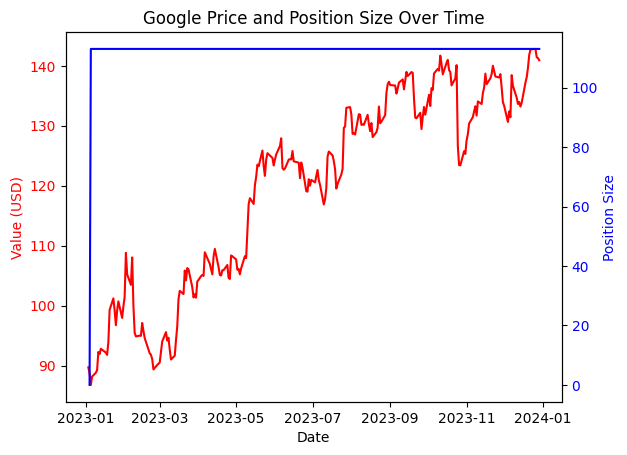

In [5]:
bnh_bt.plot(filename="../plots/buy_and_hold.html", open_browser=False)
plot_position(
    google_data_daily["Close"],
    bnh_results._strategy.position_df.set_index("Date"),
    "Google",
)

The above plotting function was constructed to minimise code repetition. This style of plot was chosen purely based on author preference. It shows the close price on the left and the position size held on the right. This style of plot makes more sense when position size changes more frequently as it is easy to match up positive and negative signals with price changes and perform a quick eye test on the signals being used.

## SMA Crossover Strategy

SMA crossover strategies are a popular entry point into algorithmic (and traditional) trading. The idea is that a shorter SMA reacts more quickly to price changes than a longer SMA, so when they cross, it may signal a shift in momentum, often indicating a short-term trend. We can use this as a trading signal in our strategies.

Note that a custom function must be created to use the `pandas` rolling average (a.k.a. SMA). This function can be viewed in the indicators helper functions file. `backtesting.py` offers an SMA function that would be ready made for this purpose, as does the popular technical analysis package [`Ta-Lib`](https://ta-lib.org), however issues with dependencies meant that these options could not be used.

In [6]:
class SMACrossover(Strategy):

    def init(self):
        """
        Initializes the strategy. Creates an empty DataFrame to store the
        position size and date. Also creates both the 7 day and 30 day SMAs.
        """
        self.position_df = pd.DataFrame(columns=["Date", "Position Size"])

        self.sma_7d = self.I(sma, self.data.Close, 7)
        self.sma_30d = self.I(sma, self.data.Close, 30)

    def next(self):
        """
        Executes on each step of the trading period.
        Buys when the 7 day SMA crosses above the 30 day SMA and sells when the
        short SMA crosses below the long SMA.
        """
        # record the current position size in the DataFrame
        new_row = {
            "Date": self.data.index[-1],
            "Position Size": self.position.size,
        }
        self.position_df = pd.concat(
            [self.position_df, pd.DataFrame([new_row])], ignore_index=True
        )

        if crossover(self.sma_7d, self.sma_30d):
            if not self.position.is_long:
                self.position.close()
                self.buy()
        elif crossover(self.sma_30d, self.sma_7d):
            if not self.position.is_short:
                self.position.close()
                self.sell()

In [7]:
sma_crossover_bt = Backtest(google_data_daily, SMACrossover, cash=10_000)

sma_crossover_results = sma_crossover_bt.run()
sma_crossover_results

Start                     2023-01-03 00:00:00
End                       2023-12-29 00:00:00
Duration                    360 days 00:00:00
Exposure Time [%]                        87.2
Equity Final [$]                  7432.209084
Equity Peak [$]                  11971.869759
Return [%]                         -25.677909
Buy & Hold Return [%]               57.112595
Return (Ann.) [%]                  -25.854148
Volatility (Ann.) [%]               19.658823
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -37.919396
Avg. Drawdown [%]                  -10.058763
Max. Drawdown Duration      106 days 00:00:00
Avg. Drawdown Duration       44 days 00:00:00
# Trades                                   10
Win Rate [%]                             20.0
Best Trade [%]                      16.603997
Worst Trade [%]                    -11.118285
Avg. Trade [%]                    

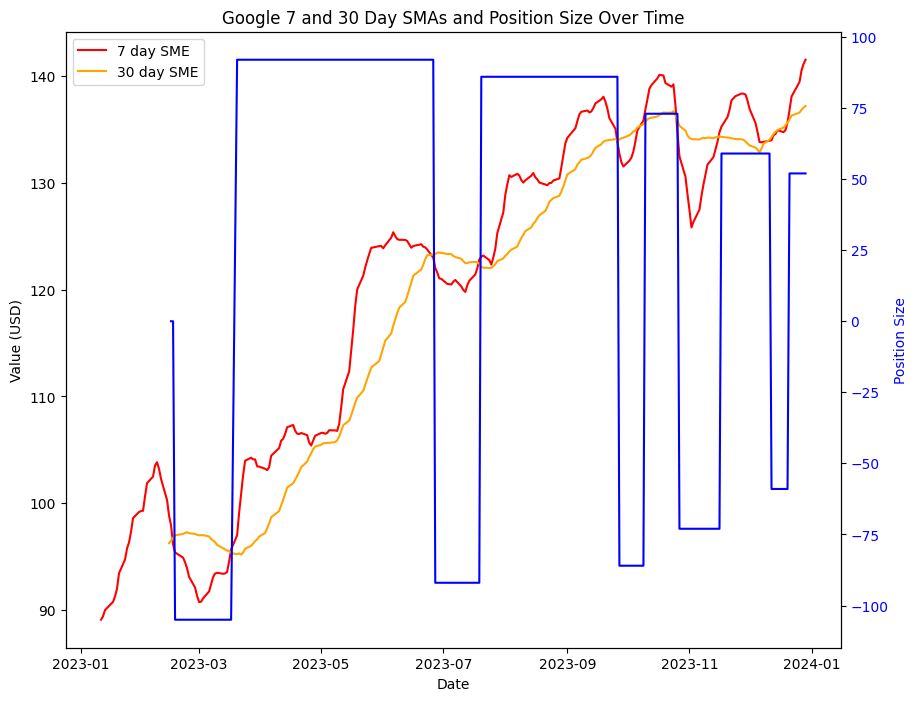

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.plot(
    google_data_daily["Close"].rolling(7).mean(),
    color="red",
    label="7 day SME",
)
ax1.plot(
    google_data_daily["Close"].rolling(30).mean(),
    color="orange",
    label="30 day SME",
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Value (USD)")
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(
    sma_crossover_results._strategy.position_df.set_index("Date"), color="blue"
)
ax2.set_ylabel("Position Size", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("Google 7 and 30 Day SMAs and Position Size Over Time")
plt.show()

The above plot shoes the points that trigger the signals to buy and sell. The sharp changes in position size aligns with the SMA crossovers as expected, albeit lagged by one day.

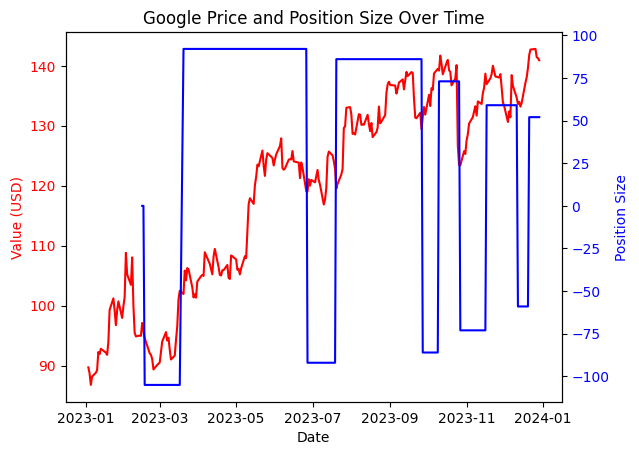

In [9]:
sma_crossover_bt.plot(
    filename="../plots/sma_crossover.html", open_browser=False
)
plot_position(
    google_data_daily["Close"],
    sma_crossover_results._strategy.position_df.set_index("Date"),
    "Google",
)

This plot shows the position sizes as the price evolves. In a perfect strategy, we would hope to see negative position size when the price is falling and a positive signal size when the price is rising.

## RSI Based Strategy


The RSI is used to measure the speed and change of price movements, first described in J. Welles Wilder's [New Concepts in Technical Trading Systems](https://books.google.co.uk/books/about/New_Concepts_in_Technical_Trading_System.html?id=WesJAQAAMAAJ&redir_esc=y). According to [ChartSchool](https://chartschool.stockcharts.com), if the RSI of an asset is around 30 or below, it would be considered oversold, whereas if the RSI is around 70 or above, it is considered overbought. We can use this principal to comstruct a signal to use in our strategies. 

In [10]:
class RSIStrategy(Strategy):
    rsi_period = 10
    rsi_underpriced = 30
    rsi_overpriced = 70

    def init(self):
        """
        Initializes the strategy. Creates an empty DataFrame to store the
        position size and date. Also creates the RSI data.
        """
        self.position_df = pd.DataFrame(columns=["Date", "Position Size"])

        self.rsi = self.I(rsi, self.data.Close, self.rsi_period)

    def next(self):
        """
        Executes on each step of the trading period.
        Enters a long position when the RSI is below 30, enters a short
        position when the RSI is above 70.
        """
        new_row = {
            "Date": self.data.index[-1],
            "Position Size": self.position.size,
        }
        self.position_df = pd.concat(
            [self.position_df, pd.DataFrame([new_row])], ignore_index=True
        )

        if self.position.is_short:
            if self.rsi < self.rsi_overpriced:
                self.position.close()

        elif self.position.is_long:
            if self.rsi > self.rsi_underpriced:
                self.position.close()

        elif (
            len(self.rsi) > self.rsi_period
        ):  # ensure we have enough datapoints to calculate the rsi
            if self.rsi > self.rsi_overpriced:
                self.sell()
            elif self.rsi < self.rsi_underpriced:
                self.buy()

In [11]:
rsi_strategy_bt = Backtest(google_data_daily, RSIStrategy, cash=10_000)

rsi_strategy_results = rsi_strategy_bt.run()
rsi_strategy_results

Start                     2023-01-03 00:00:00
End                       2023-12-29 00:00:00
Duration                    360 days 00:00:00
Exposure Time [%]                        17.2
Equity Final [$]                 10401.098618
Equity Peak [$]                  10430.618881
Return [%]                           4.010986
Buy & Hold Return [%]               57.112595
Return (Ann.) [%]                    4.043714
Volatility (Ann.) [%]               10.794642
Sharpe Ratio                         0.374604
Sortino Ratio                        0.597159
Calmar Ratio                         0.449699
Max. Drawdown [%]                   -8.992052
Avg. Drawdown [%]                    -3.62214
Max. Drawdown Duration      174 days 00:00:00
Avg. Drawdown Duration       61 days 00:00:00
# Trades                                   13
Win Rate [%]                        76.923077
Best Trade [%]                       3.171406
Worst Trade [%]                     -8.070083
Avg. Trade [%]                    

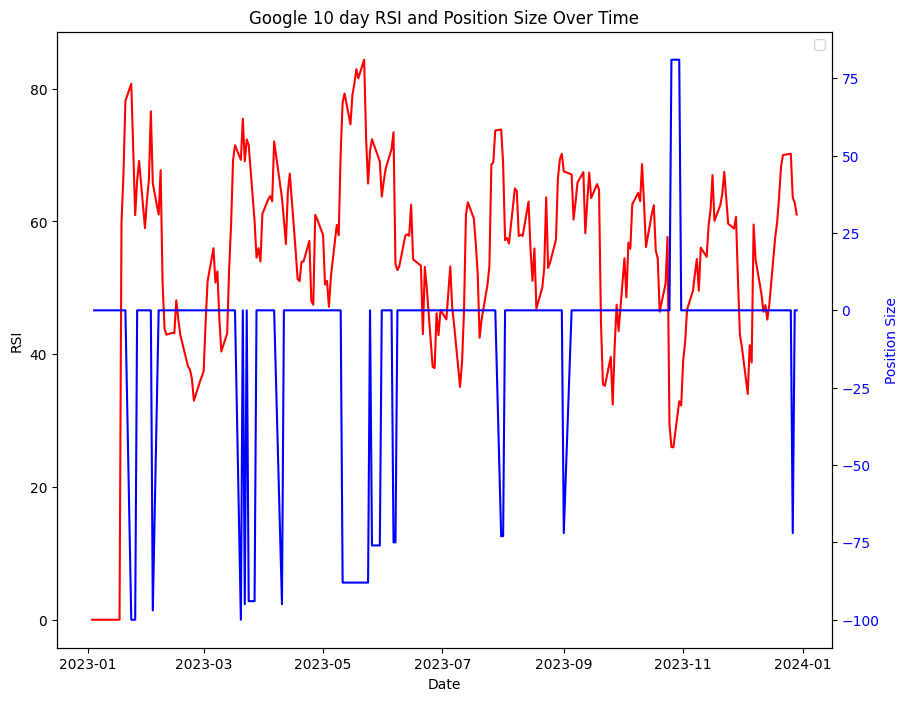

In [12]:
rsi = pd.DataFrame(rsi(google_data_daily["Close"], 10))
rsi.index = google_data_daily["Close"].index

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.plot(rsi, color="red")
ax1.set_xlabel("Date")
ax1.set_ylabel("RSI")
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(
    rsi_strategy_results._strategy.position_df.set_index("Date"), color="blue"
)
ax2.set_ylabel("Position Size", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("Google 10 day RSI and Position Size Over Time")
plt.show()

In the above plot, negative position sizes align with peaks in the RSI, and the one instance of a positive position size occurs when there is a trough in the RSI.

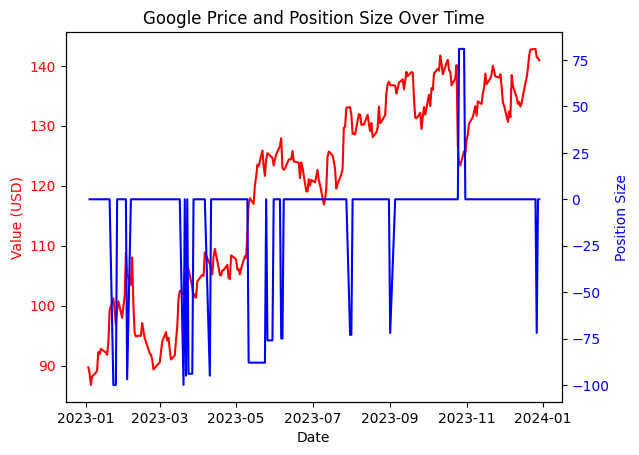

In [13]:
rsi_strategy_bt.plot(filename="../plots/rsi_strategy.html", open_browser=False)
plot_position(
    google_data_daily["Close"],
    rsi_strategy_results._strategy.position_df.set_index("Date"),
    "Google",
)

In [14]:
rsi_strategy_results["_trades"]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-100,13,16,99.129997,98.279999,84.999847,0.008575,2023-01-23,2023-01-26,3 days
1,-97,22,23,103.510002,102.684998,80.025444,0.007970,2023-02-03,2023-02-06,3 days
2,-100,52,53,101.059998,101.980003,-92.000580,-0.009104,2023-03-20,2023-03-21,1 days
3,-95,54,55,105.139999,105.889999,-71.250000,-0.007133,2023-03-22,2023-03-23,1 days
4,-94,56,58,105.739998,103.000000,257.559799,0.025913,2023-03-24,2023-03-28,4 days
5,-95,66,67,107.389999,106.919998,44.650116,0.004377,2023-04-10,2023-04-11,1 days
6,-88,89,99,115.860001,125.209999,-822.799866,-0.080701,2023-05-11,2023-05-25,14 days
7,-76,100,102,124.065002,123.699997,27.740417,0.002942,2023-05-26,2023-05-31,5 days
8,-75,106,108,126.599998,122.584999,301.124954,0.031714,2023-06-06,2023-06-08,2 days
9,-73,143,145,133.009995,129.839996,231.409866,0.023833,2023-07-31,2023-08-02,2 days


The plot and trades DataFrame shows that we were mostly exposed in short positions. It is therefore surpsing given the evident uptrend that the strategy was slightly profitable. It would be interesting to dive deeper into RSI strategies as there seems to be promise in the signals it gives.

## Next Steps

The RSI strategy showed the most promise out of the three strategies used which is unsurprising given the simplicity of the other two. In the next notebook we will dive deeper into analysis of RSI signals and attempt to derive more profitable strategies.